In [1]:
import torch
device = (torch.device('cuda') if torch.cuda.is_available()
            else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [2]:
# information
filename     = "ESPF_PretrainAE_exp"

In [3]:
import numpy as np
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, random_split
import pandas as pd

class AE_dense_3layers(nn.Module):
    def __init__(self, input_dim, mut_encode_dim, activation_func):
        super(AE_dense_3layers, self).__init__()##__init__初始化父類別的屬性和方法
        print('input_dim = ', input_dim)
        print('first_layer_dim = ', mut_encode_dim[0])
        print('second_layer_dim = ', mut_encode_dim[1])
        print('third_layer_dim = ', mut_encode_dim[2])
        # nn.Module 自己將batch 裡的samples 拆開一個一個送入self.encoder nn.Sequential
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, mut_encode_dim[0]),
            activation_func,
            nn.Linear(mut_encode_dim[0], mut_encode_dim[1]),
            activation_func,
            nn.Linear(mut_encode_dim[1], mut_encode_dim[2]),
            activation_func
        )
        self.decoder = nn.Sequential(
            nn.Linear(mut_encode_dim[2], mut_encode_dim[1]),
            activation_func,
            nn.Linear(mut_encode_dim[1], mut_encode_dim[0]),
            activation_func,
            nn.Linear(mut_encode_dim[0], input_dim),
            activation_func
        )
        # Initialize weights using He uniform initialization
        for layer in [self.encoder[0], self.encoder[2], self.encoder[4], self.decoder[0], self.decoder[2], self.decoder[4]]:
            if isinstance(layer, nn.Linear):
                init.kaiming_uniform_(layer.weight, nonlinearity='relu')

    def forward(self, x):#加self才能呼叫self裡其他的屬性和method
        x_encoded = self.encoder(x)
        x_decoded = self.decoder(x_encoded)
        return x_decoded




## def warmup_lr_scheduler

In [4]:
# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters,Decrease_percent):
    def f(epoch):
        if epoch >= warmup_iters:
          return Decrease_percent ** (epoch-warmup_iters+1)
        return 1
    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


In [5]:
import random

# Function to set the seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# Set the seed
seed = 42
set_seed(seed)

In [6]:
# load TCGA mutation data, substitute here with other genomics
data_mut_tcga= pd.read_csv("../data/TCGA/TCGA_exp_matchCCLEgenes_8238samples_4692genes.txt", sep='\t', index_col=0)

print("\n\nDatasets successfully loaded.")



Datasets successfully loaded.


In [7]:
data_mut_tcga.shape

(8238, 4692)

In [8]:
# #exchange the row and column to match the format of doctor chiu's data (row is gene ;column is cancer)
# data_mut_tcga=data_mut_tcga.transpose()
# data_mut_tcga.shape

## 也許應該要分train validation set，這樣才能更學到真正重要的特徵，而不是背答案

In [9]:
if __name__ == '__main__':#被別人呼叫的時候不會執行main以下的程式，只會執行

    input_dim = data_mut_tcga.shape[1]# (8238sample[0], 2649gene[1])
    mut_encode_dim =[1250,250,50]
    batch_size = 64
    epoch_size = 300 #100
    activation_function = nn.ReLU()
    model_save_name = "tcga_exp_%d_%d_%d" % (mut_encode_dim[0], mut_encode_dim[1], mut_encode_dim[2])
    learning_rate=0.001
    warmup_iters = 185
    seed=42
    patience = 25
    Decrease_percent = 1
    

    torch.manual_seed(seed)
    np.random.seed(seed)
    train_size = int(0.8 * len(data_mut_tcga))
    test_size = len(data_mut_tcga) - train_size
    # Split data into training and testing sets
    train_data, test_data = random_split(data_mut_tcga.values, [train_size, test_size])

    # Create DataLoaders for training and testing
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    t = time.time()
    torch.manual_seed(seed)
    model = AE_dense_3layers(input_dim=input_dim, mut_encode_dim=mut_encode_dim, activation_func=activation_function).to(device=device)
    criterion = nn.MSELoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    if warmup_iters is not None:
        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters,Decrease_percent)
    
    # Training with early stopping (assuming you've defined the EarlyStopping logic)
    
    best_val_loss = float('inf')
    best_weight=None
    counter = 0
    train_epoch_loss_list = []#  for train every epoch loss plot
    test_epoch_loss_list=[]#  for validation every epoch loss plot
    torch.manual_seed(seed)

    for epoch in range(epoch_size):
        model.train()
        model.requires_grad = True
        total_train_loss = 0.0
        for batch_idx,inputs in enumerate(train_loader):
            optimizer.zero_grad()
            inputs =inputs.float().to(device=device) # change torch.Tensor int64 to float32
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() # sum every batch's loss to compute average loss of every batch for one epoch
            #print(f'Epoch {epoch + 1}/{epoch_size} - Batch {batch_idx+1}/{len(dataloader_mut_tcga)} - Loss: {loss.item():.4f}')#batch loss()
        # Calculate and print the average loss of batch for the epoch
        average_loss = total_train_loss / len(train_loader) # 一個 epoch 的 loss 是 batch 的 average loss
        train_epoch_loss_list.append(average_loss)# for loss plot'
        print(f'Epoch {epoch + 1}/{epoch_size} - Train Loss: {average_loss:.8f}')
        
        model.eval()
        model.requires_grad = False
        total_test_loss = 0.0
        
        with torch.no_grad():
            for batch_idx,inputs in enumerate(test_loader):
                inputs =inputs.float().to(device=device) # change torch.Tensor int64 to float32
                outputs = model(inputs)
                test_loss = criterion(outputs, inputs)
                total_test_loss += test_loss.item() 
        test_average_loss = total_test_loss / len(test_loader)
        test_epoch_loss_list.append(test_average_loss)# for loss plot'
        print(f'Epoch {epoch + 1}/{epoch_size} - Test Loss: {test_average_loss:.8f}')

        if warmup_iters:
            print("lr of epoch", epoch + 1, "=>", lr_scheduler.get_lr()) 
            lr_scheduler.step()
        
        if test_average_loss < best_val_loss:
            best_val_loss = test_average_loss
            best_weight = copy.deepcopy(model.state_dict())
            best_epoch = epoch+1
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping after {patience} epochs of no improvement.')
                break
                

input_dim =  4692
first_layer_dim =  1250
second_layer_dim =  250
third_layer_dim =  50
Epoch 1/300 - Train Loss: 7.22055740
Epoch 1/300 - Test Loss: 6.07800706
lr of epoch 1 => [0.001]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:265: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 2/300 - Train Loss: 6.10093148
Epoch 2/300 - Test Loss: 6.07180021
lr of epoch 2 => [0.001]
Epoch 3/300 - Train Loss: 6.08846956
Epoch 3/300 - Test Loss: 6.06979579
lr of epoch 3 => [0.001]
Epoch 4/300 - Train Loss: 6.04143737
Epoch 4/300 - Test Loss: 6.20666852
lr of epoch 4 => [0.001]
Epoch 5/300 - Train Loss: 5.99578038
Epoch 5/300 - Test Loss: 5.95218737
lr of epoch 5 => [0.001]
Epoch 6/300 - Train Loss: 5.99038140
Epoch 6/300 - Test Loss: 5.97679443
lr of epoch 6 => [0.001]
Epoch 7/300 - Train Loss: 5.95332549
Epoch 7/300 - Test Loss: 5.92964803
lr of epoch 7 => [0.001]
Epoch 8/300 - Train Loss: 5.93885731
Epoch 8/300 - Test Loss: 5.89847942
lr of epoch 8 => [0.001]
Epoch 9/300 - Train Loss: 5.89978550
Epoch 9/300 - Test Loss: 5.82800225
lr of epoch 9 => [0.001]
Epoch 10/300 - Train Loss: 5.83130629
Epoch 10/300 - Test Loss: 5.78674421
lr of epoch 10 => [0.001]
Epoch 11/300 - Train Loss: 5.77675589
Epoch 11/300 - Test Loss: 5.71021265
lr of epoch 11 => [0.001]
Epoch 12/300 -

RuntimeError: Parent directory /root/DeepTTA/results does not exist.

In [10]:
encoder_best_weight = {key: value for key, value in best_weight.items() if key.startswith('encoder')} # only store the encoder part without decoder part
torch.save(encoder_best_weight, f'./results/Encoder_{model_save_name}_best_loss_{best_val_loss:.8}.pt')

print('batch_size:',batch_size," ",'activation_function:',activation_function," ",
      'learning_rate:',learning_rate," ",'warmup_iters:',warmup_iters)
print("best Epoch : ",best_epoch," ," ,"best_val_loss : ",best_val_loss)
print('\nAutoencoder training completed in %.1f mins.\n' % ((time.time() - t) / 60))

batch_size: 64   activation_function: ReLU()   learning_rate: 0.001   warmup_iters: 185
best Epoch :  291  , best_val_loss :  3.035458757327153

Autoencoder training completed in 71.2 mins.



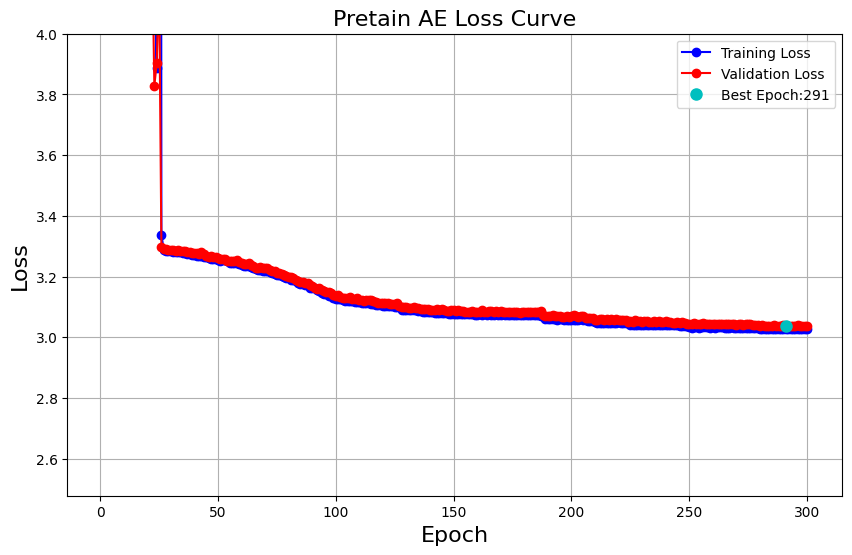

In [13]:
import matplotlib.pyplot as plt
# Create a plot of the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_epoch_loss_list) + 1), train_epoch_loss_list, marker='o', linestyle='-', color='b', label='Training Loss')
# Plot validation loss
plt.plot(range(1, len(test_epoch_loss_list) + 1), test_epoch_loss_list, marker='o', linestyle='-', color='r', label='Validation Loss')
# Mark the best epoch
plt.plot(best_epoch, best_val_loss , marker='o', markersize=8, linestyle='', color='c', label=f'Best Epoch:{best_epoch}')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Pretain AE Loss Curve', fontsize=16)
plt.legend()
plt.grid(True)
plt.ylim(top=4)
plt.show()
